# Fundamento del modelo

La Regresión Logística es un modelo estadístico supervisado lineal que predice la probabilidad de pertenecer a una clase (por ejemplo, si un cliente se va o permanece).

## Proceso aplicado al dataset

Variable objetivo:

  - exited → 1 = el cliente abandonó, 0 = permaneció.

Entrenamiento/test split: 75% / 25%

Preprocesamiento:

  - Escalado numérico (StandardScaler)
  - Codificación de variables categóricas (OneHotEncoder)

In [1]:
# -*- coding: utf-8 -*-
# Clasificación (churn) con REGRESIÓN LOGÍSTICA + métricas de clasificación y gráficas con Seaborn

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
)

In [2]:
# ---------------------
# 1) Carga y preparación
# ---------------------
BASE = Path("../../")  # ajústalo si corresponde
DATA = BASE / "Churn_Modelling-ETL 2.csv"

df = pd.read_csv(DATA)
df.columns = [c.strip().replace(" ", "_") for c in df.columns]  # snake_case

target_col = "exited" if "exited" in df.columns else "Exited"
assert target_col in df.columns, "No se encontró la columna objetivo ('exited' o 'Exited')."

# Quitar identificadores sin valor predictivo directo
drop_ids = [c for c in ["row_number", "customer_id", "surname", "RowNumber", "CustomerId", "Surname"] if c in df.columns]
X = df.drop(columns=[target_col] + drop_ids, errors="ignore")
y = df[target_col].astype(int)

# Columnas
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

In [3]:
# ---------------------
# 2) Pipeline de preprocesamiento + modelo
# ---------------------
preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
])

logreg = LogisticRegression(max_iter=1000, random_state=42)

pipe = Pipeline([
    ("prep", preprocess),
    ("clf", logreg),
])

In [4]:
# ---------------------
# 3) Train/Test split
# ---------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Entrena
pipe.fit(X_train, y_train)


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [5]:
# ---------------------
# 4) Predicción y métricas (clasificación)
# ---------------------
y_prob = pipe.predict_proba(X_test)[:, 1]   # prob de clase positiva
y_pred = (y_prob >= 0.50).astype(int)       # umbral por defecto 0.5

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, y_prob)
cm   = confusion_matrix(y_test, y_pred)

print(f"Accuracy     : {acc:.4f}")
print(f"Precision(1) : {prec:.4f}")
print(f"Recall(1)    : {rec:.4f}")
print(f"F1(1)        : {f1:.4f}")
print(f"ROC-AUC      : {auc:.4f}")
print("Matriz de confusión:\n", cm)

Accuracy     : 0.8324
Precision(1) : 0.7083
Recall(1)    : 0.3006
F1(1)        : 0.4221
ROC-AUC      : 0.8067
Matriz de confusión:
 [[1928   63]
 [ 356  153]]


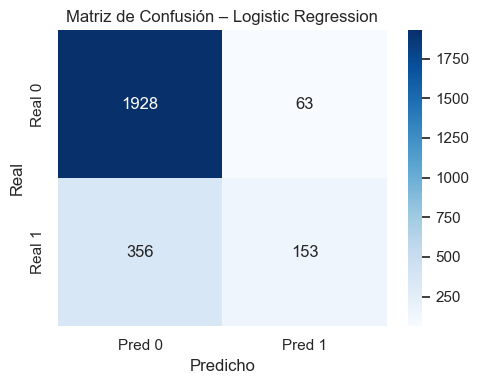

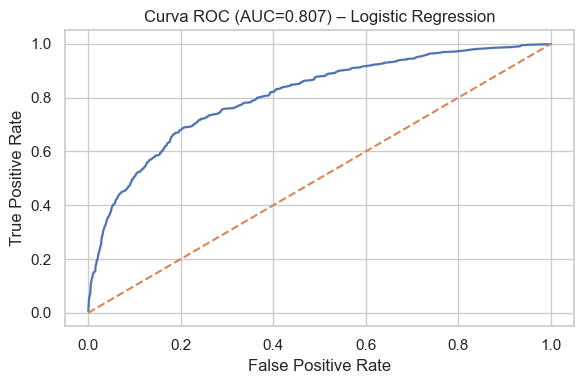

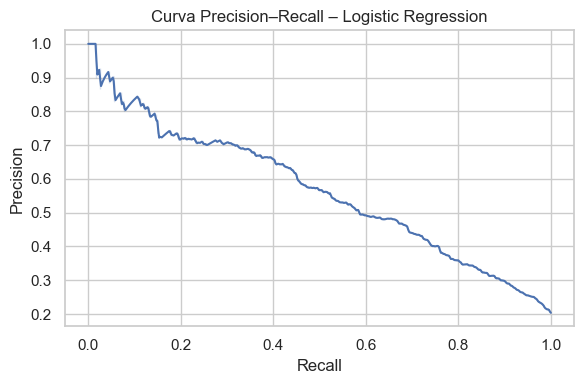

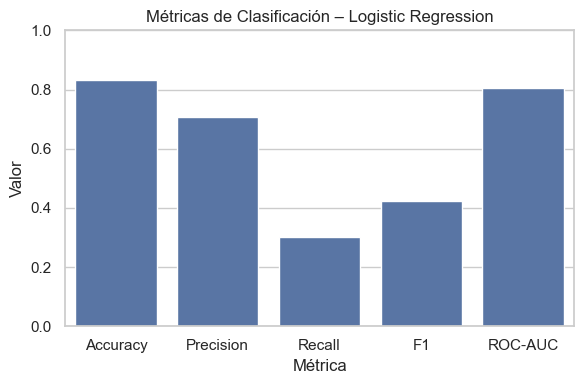


== Umbral personalizado (0.35) ==
Accuracy     : 0.8128
Precision(1) : 0.5411
Recall(1)    : 0.5305
F1(1)        : 0.5357
Matriz de confusión (umbral custom):
 [[1762  229]
 [ 239  270]]


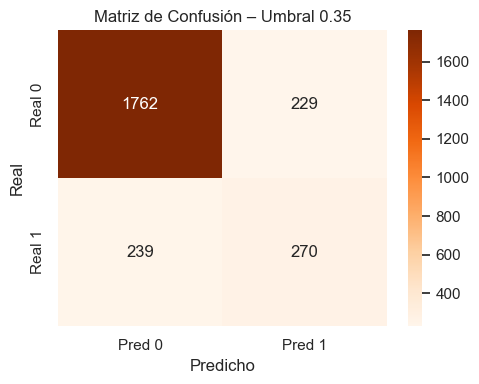

In [6]:
# ---------------------
# 5) Gráficas con Seaborn
# ---------------------
sns.set(style="whitegrid")

# a) Matriz de confusión (heatmap)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0","Pred 1"], yticklabels=["Real 0","Real 1"])
plt.title("Matriz de Confusión – Logistic Regression")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# b) Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
sns.lineplot(x=fpr, y=tpr)
sns.lineplot(x=[0,1], y=[0,1], linestyle="--")  # diagonal
plt.title(f"Curva ROC (AUC={auc:.3f}) – Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()
plt.show()

# c) Curva Precision–Recall
precisions, recalls, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
sns.lineplot(x=recalls, y=precisions)
plt.title("Curva Precision–Recall – Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()

# d) Barras de métricas
metrics_df = pd.DataFrame({
    "Métrica": ["Accuracy","Precision","Recall","F1","ROC-AUC"],
    "Valor":   [acc, prec, rec, f1, auc]
})
plt.figure(figsize=(6,4))
sns.barplot(data=metrics_df, x="Métrica", y="Valor")
plt.ylim(0,1)
plt.title("Métricas de Clasificación – Logistic Regression")
plt.tight_layout()
plt.show()

# ---------------------
# 6) (Opcional) mover el umbral para priorizar recall
# ---------------------
thr = 0.35  # ejemplo: bajar umbral para ganar recall
y_pred_thr = (y_prob >= thr).astype(int)
acc2  = accuracy_score(y_test, y_pred_thr)
prec2 = precision_score(y_test, y_pred_thr, zero_division=0)
rec2  = recall_score(y_test, y_pred_thr, zero_division=0)
f12   = f1_score(y_test, y_pred_thr, zero_division=0)
cm2   = confusion_matrix(y_test, y_pred_thr)

print(f"\n== Umbral personalizado ({thr:.2f}) ==")
print(f"Accuracy     : {acc2:.4f}")
print(f"Precision(1) : {prec2:.4f}")
print(f"Recall(1)    : {rec2:.4f}")
print(f"F1(1)        : {f12:.4f}")
print("Matriz de confusión (umbral custom):\n", cm2)

plt.figure(figsize=(5,4))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["Pred 0","Pred 1"], yticklabels=["Real 0","Real 1"])
plt.title(f"Matriz de Confusión – Umbral {thr:.2f}")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.tight_layout()
plt.show()
